# Cart Pole using DQN (Deep Q Network)

In [70]:
%matplotlib inline


from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
import keras.backend as K
from keras import losses

import gym

import random
import numpy as np
from collections import deque

import matplotlib.pyplot as plt

seed = 7
np.random.seed(seed)

# Class Variables
state_size = state of game like angle, position <br>
action_size = action like 0(move right) and 1(move left) <br>
memory = store the experience <br>
gamma = discount rate (to find future discounted reward ) <br>
epsilon - exploration rate (take random steps rather than using model's prediction to explore)<br>
epsion_decay = as model keeps learning we want to take predicted steps rather than random one<br>
learning_rate - rate of learning (by how much values are updated in layers)<br>


# Class Methods

_build_model = returns keras model
remember = store the experiences<br>
act = returns the action to be taken<br>
replay - trains the model with stored experiences

In [71]:
class Agent(object):
    
    def __init__(self,state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen = 2000)
        self.gamma = 0.95         #discount rate
        self.epsilon = 1.0        #exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.99
        self.learning_rate = 0.0001
        self.model = self._build_model()
        
        
    def _loss(self, target, prediction):
        error = prediction - target
        return K.mean(K.sqrt(1+K.square(error))-1, axis=-1)
    
    def _build_model(self):
        model = Sequential()
        model.add(Dense(64, input_dim=self.state_size, activation='relu'))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss= losses.mean_squared_error,
                      optimizer=Adam(lr=self.learning_rate))
        return model
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append( (state, action, reward, next_state, done) )
        
    def act(self, state):
        
        #select the random action
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        
        #select the actions based on model's prediction
        action = self.model.predict(state)
        
        return np.argmax(action[0])
    
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        
        for state, action, reward, next_state, done in minibatch:
            target = reward        #target is reward if game is finished
            
            #if game not finished then calculate the discounted future reward
            #now the target is the future discounted reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0] )
            
            target_f = self.model.predict(state)
            target_f[0][action] = target
            
            self.model.fit(state, target_f, epochs=1, verbose=0)
            
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay  
    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

# Now lets train the model

In [72]:
env = gym.make('CartPole-v0')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
episodes = 80
batch_size = 32
agent = Agent(state_size, action_size)

for i in range(episodes):
    state = env.reset()
    
    for time in range(500):
#         env.render()
        state = np.reshape(state, (1,state_size))
        action = agent.act(state)             #take action in the game
        
        next_state, reward, done, _ = env.step(action)    #get the next states of the game
        next_state = np.reshape(next_state, (1,state_size))
        
        reward = reward if not done else -0.5
        
        agent.remember(state, action, reward, next_state, done) # store the experience
        
        state = next_state
        
        # if game finished the calculate the score and move to next episode
        if done:
            print 'episode: {}/{}, score: {}'.format(i, episodes, time)
            break
        
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)

WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
episode: 0/80, score: 11
episode: 1/80, score: 30
episode: 2/80, score: 8
episode: 3/80, score: 9
episode: 4/80, score: 9
episode: 5/80, score: 9
episode: 6/80, score: 7
episode: 7/80, score: 9
episode: 8/80, score: 10
episode: 9/80, score: 8
episode: 10/80, score: 9
episode: 11/80, score: 7
episode: 12/80, score: 8
episode: 13/80, score: 10
episode: 14/80, score: 9
episode: 15/80, score: 10
episode: 16/80, score: 17
episode: 17/80, score: 66
episode: 18/80, score: 17
episode: 19/80, score: 14
episode: 20/80, score: 16
episode: 21/80, score: 20
episode: 22/80, score: 61
episode: 23/80, score: 45
episode: 24/80, score: 50
episode: 25/80, score: 79
episode: 26/80, score: 76
episode: 27/80, score: 60
episode: 28/80, score: 99
episode: 29/80, score: 109
episode: 30/80, score: 107
episode: 31/80, score: 128
episode: 32/80, score: 156
episode: 33/80, score: 155
episode: 34/80, score: 154
episode

In [73]:
agent.save('dqn.h5')

In [74]:
state  = env.reset()
score = []

for e in range(100):
    for time in range(200):
        state = np.reshape(state,(1,state_size))
        action = agent.model.predict(state)[0]
        action = np.argmax(action)
        next_state, reward, done, _ = env.step(action)
        state = next_state
        
        if done:
            score.append(time)
            state = env.reset()
            break

In [75]:
print "mean score is {}".format(np.mean(score))

mean score is 160.5


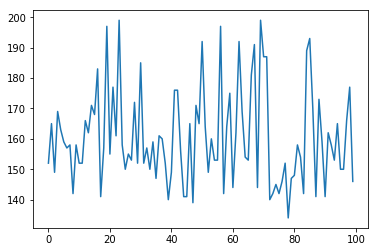

In [76]:
plt.plot(score)